In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif

sns.set(style="whitegrid")

In [6]:
url = "https://huggingface.co/datasets/nprak26/remote-worker-productivity/raw/main/remote_work_productivity.csv"
df = pd.read_csv(url)

relevant_columns = ['Age', 'Years_Experience', 'Work_Hours_Per_Week', 'Productivity_Score', 
                    'Meetings_Per_Week', 'Job_Satisfaction', 'Education_Level', 'Department', 
                    'Job_Level', 'Has_Children', 'Location_Type', 'Company_Size', 'WFH_Days_Per_Week']
df = df[relevant_columns]
df.head()

,Age,Years_Experience,Work_Hours_Per_Week,Productivity_Score,Meetings_Per_Week,Job_Satisfaction,Education_Level,Department,Job_Level,Has_Children,Location_Type,Company_Size,WFH_Days_Per_Week
0,39,10,41,52.2,4,55.9,Associate Degree,Product,Mid-Level,Yes,Urban,Large (1001-5000),2
1,33,4,52,81.5,12,96.1,Master Degree,Customer Success,Senior,No,Urban,Startup (1-50),5
2,40,3,43,82.2,15,90.4,PhD,Operations,Mid-Level,Yes,Rural,Medium (201-1000),3
3,48,14,45,75.6,8,100.0,Bachelor Degree,Finance,Manager,Yes,Urban,Medium (201-1000),3
4,32,6,42,98.0,10,100.0,High School,Engineering,Senior,Yes,Rural,Small (51-200),5


In [7]:
# missing data checks (totals + per column)
total_missing = df.isnull().sum().sum()
print(f"total missing values in dataset: {total_missing}")
if total_missing == 0:
    print("no missing values found - dataset is clean.")

missing_per_column = df.isnull().sum()
print("Missing values per column:\n", missing_per_column)

total missing values in dataset: 0
no missing values found - dataset is clean.
Missing values per column:
 Age                    0
Years_Experience       0
Work_Hours_Per_Week    0
Productivity_Score     0
Meetings_Per_Week      0
Job_Satisfaction       0
Education_Level        0
Department             0
Job_Level              0
Has_Children           0
Location_Type          0
Company_Size           0
WFH_Days_Per_Week      0
dtype: int64


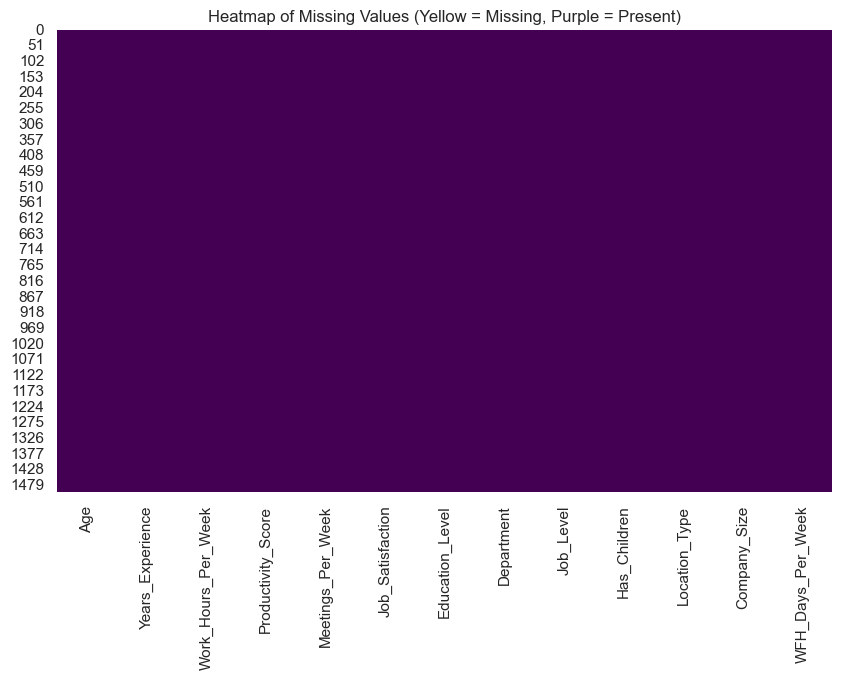

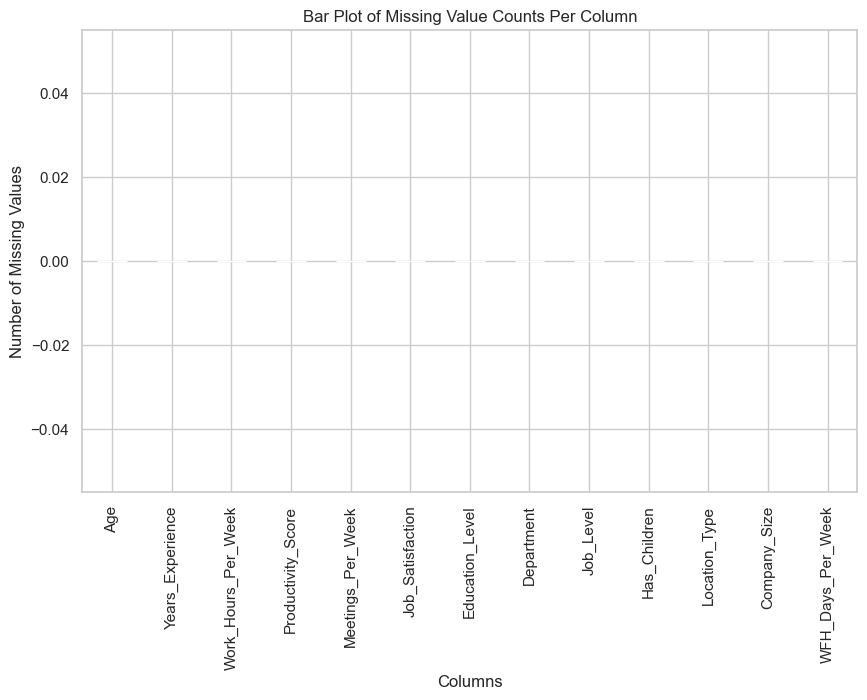

In [13]:
# EDA - Missingness heatmap and barplot
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title("Heatmap of Missing Values (Yellow = Missing, Purple = Present)")
plt.savefig("../results/eda_visualizations/missing_values_heatmap.png")
plt.show()

missing_counts = df.isnull().sum()
plt.figure(figsize=(10, 6))
missing_counts.plot(kind='bar', color='blue')
plt.title("Bar Plot of Missing Value Counts Per Column")
plt.xlabel("Columns")
plt.ylabel("Number of Missing Values")
plt.savefig("../results/eda_visualizations/missing_values_barplot.png")
plt.show()

In [14]:
# Outlier detection (IQR) on numeric columns
num_cols = ['Age', 'Years_Experience', 'Work_Hours_Per_Week', 'Productivity_Score', 'Meetings_Per_Week', 'Job_Satisfaction']
df_num = df[num_cols]

Q1 = df_num.quantile(0.25)
Q3 = df_num.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = ((df_num < lower_bound) | (df_num > upper_bound)).sum()
print("Number of outliers per column:\n", outliers)

Number of outliers per column:
 Age                      2
Years_Experience        47
Work_Hours_Per_Week      2
Productivity_Score      13
Meetings_Per_Week        7
Job_Satisfaction       317
dtype: int64


Original shape: (1500, 13), After outlier removal: (1131, 13)


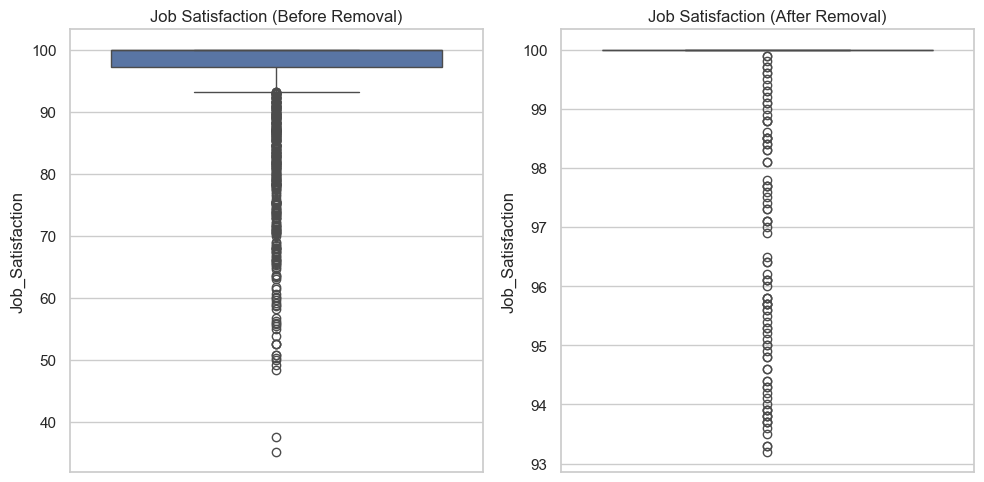

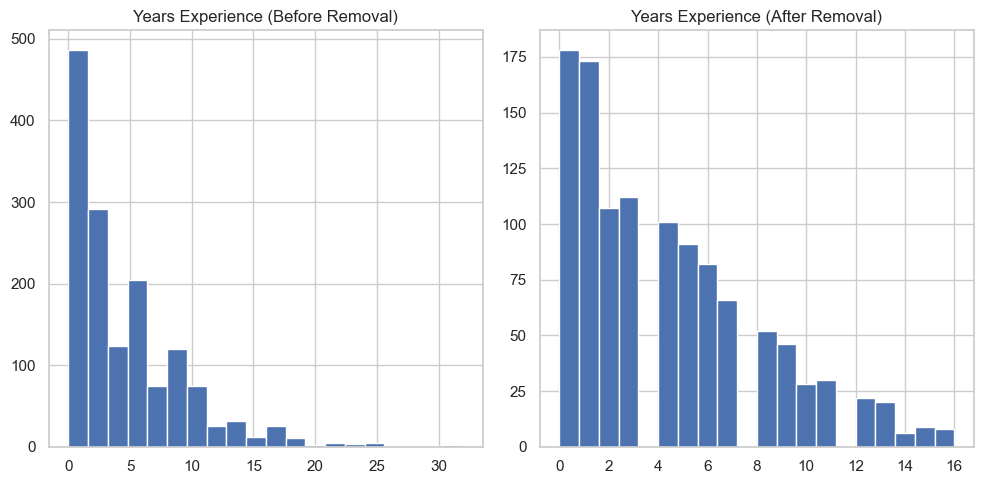

In [15]:
# Remove outliers + EDA before/after
df_clean = df[~((df_num < lower_bound) | (df_num > upper_bound)).any(axis=1)]
print(f"Original shape: {df.shape}, After outlier removal: {df_clean.shape}")

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.boxplot(y=df['Job_Satisfaction'])
plt.title("Job Satisfaction (Before Removal)")
plt.subplot(1, 2, 2)
sns.boxplot(y=df_clean['Job_Satisfaction'])
plt.title("Job Satisfaction (After Removal)")
plt.tight_layout()
plt.savefig("../results/eda_visualizations/job_satisfaction_before_after.png")
plt.show()

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(df['Years_Experience'], bins=20)
plt.title("Years Experience (Before Removal)")
plt.subplot(1, 2, 2)
plt.hist(df_clean['Years_Experience'], bins=20)
plt.title("Years Experience (After Removal)")
plt.tight_layout()
plt.savefig("../results/eda_visualizations/years_experience_before_after.png")
plt.show()

In [16]:
# One-hot encoding of categorical columns on cleaned data
cat_cols = ['Has_Children', 'Location_Type']
df_cat = df_clean[cat_cols]

encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_data = encoder.fit_transform(df_cat)
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(cat_cols), index=df_clean.index)

df_encoded = pd.concat([df_clean.drop(columns=cat_cols), encoded_df], axis=1)
df_encoded.head()

,Age,Years_Experience,Work_Hours_Per_Week,Productivity_Score,Meetings_Per_Week,Job_Satisfaction,Education_Level,Department,Job_Level,Company_Size,WFH_Days_Per_Week,Has_Children_Yes,Location_Type_Suburban,Location_Type_Urban
1,33,4,52,81.5,12,96.1,Master Degree,Customer Success,Senior,Startup (1-50),5,0.0,0.0,1.0
3,48,14,45,75.6,8,100.0,Bachelor Degree,Finance,Manager,Medium (201-1000),3,1.0,0.0,1.0
4,32,6,42,98.0,10,100.0,High School,Engineering,Senior,Small (51-200),5,1.0,0.0,0.0
5,32,7,43,62.0,7,100.0,Bachelor Degree,HR,Mid-Level,Medium (201-1000),4,0.0,0.0,1.0
6,49,1,38,66.2,10,100.0,High School,Marketing,Junior,Enterprise (5000+),2,0.0,1.0,0.0


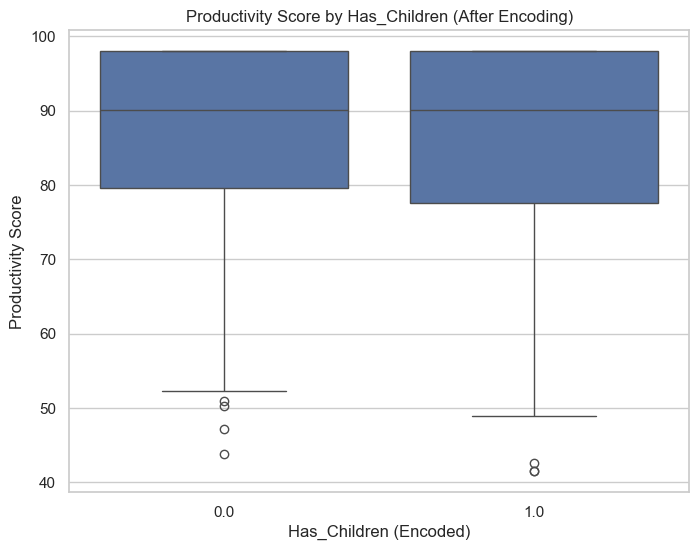

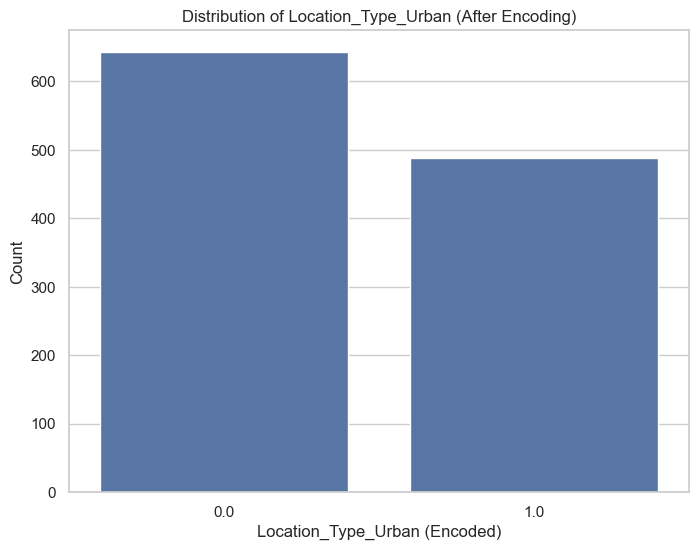

In [17]:
# EDA - Encoded features
plt.figure(figsize=(8, 6))
sns.boxplot(x='Has_Children_Yes', y='Productivity_Score', data=df_encoded)
plt.title("Productivity Score by Has_Children (After Encoding)")
plt.xlabel("Has_Children (Encoded)")
plt.ylabel("Productivity Score")
plt.savefig("../results/eda_visualizations/productivity_by_has_children_encoded.png")
plt.show()

plt.figure(figsize=(8, 6))
sns.countplot(x='Location_Type_Urban', data=df_encoded)
plt.title("Distribution of Location_Type_Urban (After Encoding)")
plt.xlabel("Location_Type_Urban (Encoded)")
plt.ylabel("Count")
plt.savefig("../results/eda_visualizations/location_type_urban_distribution_encoded.png")
plt.show()

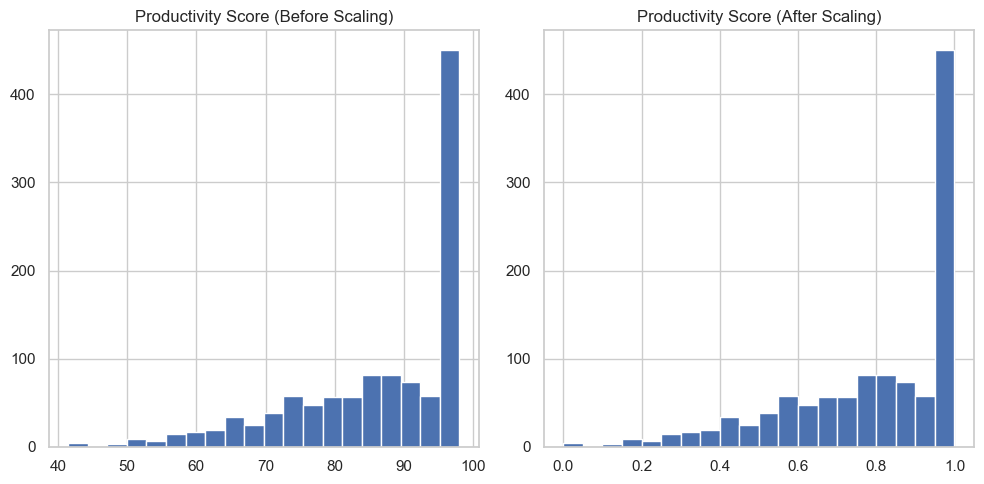

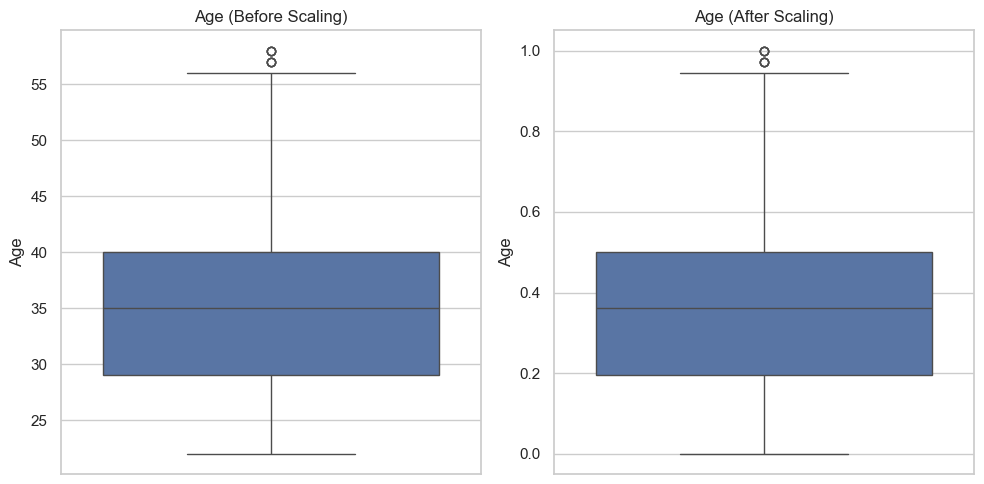

,Age,Years_Experience,Work_Hours_Per_Week,Productivity_Score,Meetings_Per_Week,Job_Satisfaction,Education_Level,Department,Job_Level,Company_Size,WFH_Days_Per_Week,Has_Children_Yes,Location_Type_Suburban,Location_Type_Urban
1,0.305556,0.2500,0.794118,0.707965,0.733333,0.426471,Master Degree,Customer Success,Senior,Startup (1-50),5,0.0,0.0,1.0
3,0.722222,0.8750,0.588235,0.603540,0.466667,1.000000,Bachelor Degree,Finance,Manager,Medium (201-1000),3,1.0,0.0,1.0
4,0.277778,0.3750,0.500000,1.000000,0.600000,1.000000,High School,Engineering,Senior,Small (51-200),5,1.0,0.0,0.0
5,0.277778,0.4375,0.529412,0.362832,0.400000,1.000000,Bachelor Degree,HR,Mid-Level,Medium (201-1000),4,0.0,0.0,1.0
6,0.750000,0.0625,0.382353,0.437168,0.600000,1.000000,High School,Marketing,Junior,Enterprise (5000+),2,0.0,1.0,0.0


In [18]:
#MinMax scaling of numeric columns
num_cols = ['Age', 'Years_Experience', 'Work_Hours_Per_Week', 'Productivity_Score', 'Meetings_Per_Week', 'Job_Satisfaction']
df_num_enc = df_encoded[num_cols]

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_num_enc)
df_scaled_num = pd.DataFrame(scaled_data, columns=num_cols, index=df_encoded.index)
df_scaled = pd.concat([df_scaled_num, df_encoded.drop(columns=num_cols)], axis=1)

# EDA before/after scaling for key features
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(df_clean['Productivity_Score'], bins=20)
plt.title("Productivity Score (Before Scaling)")
plt.subplot(1, 2, 2)
plt.hist(df_scaled['Productivity_Score'], bins=20)
plt.title("Productivity Score (After Scaling)")
plt.tight_layout()
plt.savefig("../results/eda_visualizations/productivity_before_after_scaling.png")
plt.show()

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.boxplot(y=df_clean['Age'])
plt.title("Age (Before Scaling)")
plt.subplot(1, 2, 2)
sns.boxplot(y=df_scaled['Age'])
plt.title("Age (After Scaling)")
plt.tight_layout()
plt.savefig("../results/eda_visualizations/age_before_after_scaling.png")
plt.show()

df_scaled.head()

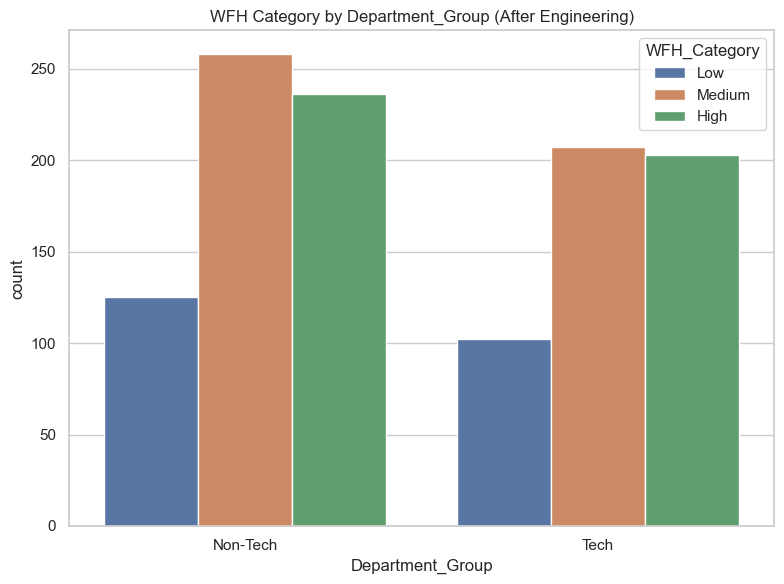

In [19]:
# Feature engineering (groupings) + target
df_eng = df_scaled.copy()

df_eng['Department_Group'] = df_eng['Department'].apply(lambda x: 'Tech' if x in ['Engineering', 'Data Science', 'Product', 'Design'] else 'Non-Tech')
df_eng['Education_Group'] = df_eng['Education_Level'].replace({
    'High School': 'Basic', 'Associate Degree': 'Basic',
    'Bachelor Degree': 'Bachelor/Master', 'Master Degree': 'Bachelor/Master',
    'PhD': 'Advanced', 'Professional Degree': 'Advanced'
})
df_eng['Job_Level_Group'] = df_eng['Job_Level'].apply(lambda x: 'Junior' if x in ['Junior', 'Mid-Level'] else 'Senior')
df_eng['Company_Size_Group'] = df_eng['Company_Size'].apply(lambda x: 'Small' if x in ['Startup (1-50)', 'Small (51-200)'] else 'Large')

df_engineered = df_eng.drop(columns=['Department', 'Education_Level', 'Job_Level', 'Company_Size'])

df_engineered['WFH_Category'] = pd.cut(df_engineered['WFH_Days_Per_Week'], bins=[-1, 1, 3, 5], labels=['Low', 'Medium', 'High'])

plt.figure(figsize=(8, 6))
sns.countplot(x='Department_Group', hue='WFH_Category', data=df_engineered)
plt.title("WFH Category by Department_Group (After Engineering)")
plt.tight_layout()
plt.savefig("../results/eda_visualizations/wfh_by_department_group.png")
plt.show()

Selected features: ['Age', 'Productivity_Score', 'Meetings_Per_Week', 'Job_Satisfaction']


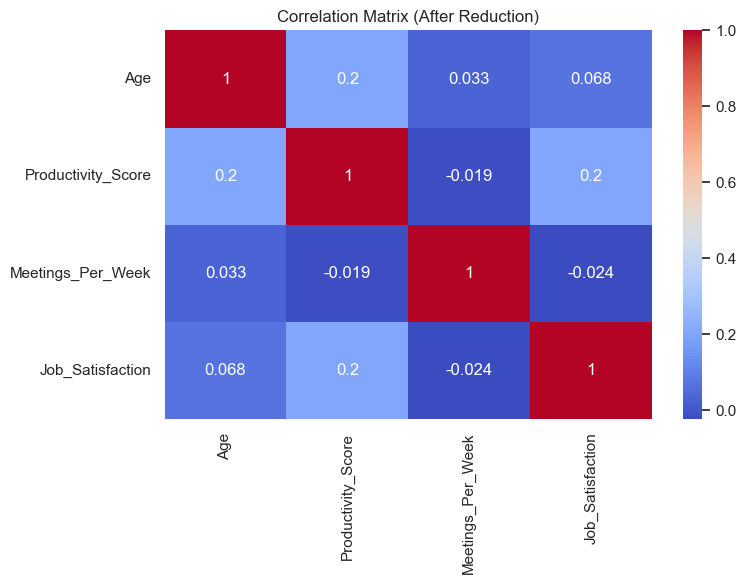

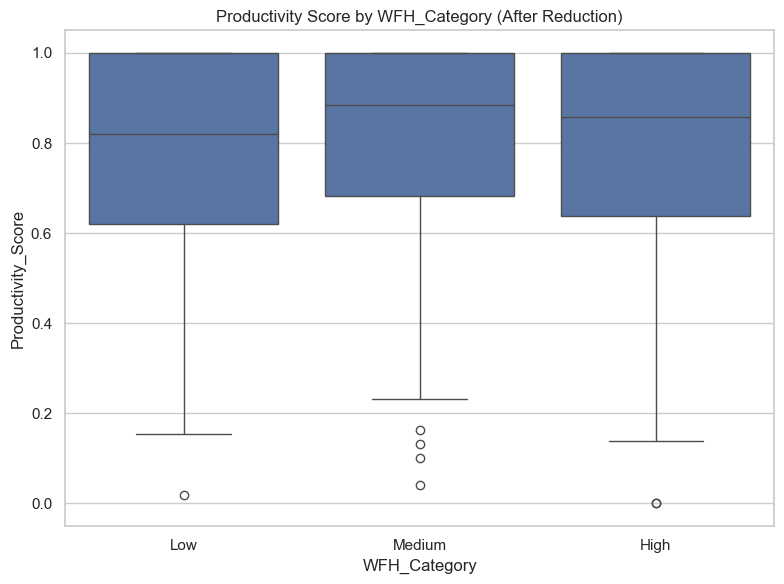

,Age,Productivity_Score,Meetings_Per_Week,Job_Satisfaction,WFH_Days_Per_Week,Has_Children_Yes,Location_Type_Suburban,Location_Type_Urban,Department_Group,Education_Group,Job_Level_Group,Company_Size_Group,WFH_Category
1,0.305556,0.707965,0.733333,0.426471,5,0.0,0.0,1.0,Non-Tech,Bachelor/Master,Senior,Small,High
3,0.722222,0.603540,0.466667,1.000000,3,1.0,0.0,1.0,Non-Tech,Bachelor/Master,Senior,Large,Medium
4,0.277778,1.000000,0.600000,1.000000,5,1.0,0.0,0.0,Tech,Basic,Senior,Small,High
5,0.277778,0.362832,0.400000,1.000000,4,0.0,0.0,1.0,Non-Tech,Bachelor/Master,Junior,Large,High
6,0.750000,0.437168,0.600000,1.000000,2,0.0,1.0,0.0,Non-Tech,Basic,Junior,Large,Medium


In [20]:
# Feature selection (SelectKBest on numeric features) + EDA after reduction
y = df_engineered['WFH_Category']

num_cols = ['Age', 'Years_Experience', 'Work_Hours_Per_Week', 'Productivity_Score', 'Meetings_Per_Week', 'Job_Satisfaction']
X = df_engineered[num_cols]

selector = SelectKBest(score_func=f_classif, k=4)
X_selected = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()].tolist()
print("Selected features:", selected_features)

df_reduced = pd.DataFrame(X_selected, columns=selected_features, index=df_engineered.index)
df_reduced = pd.concat([df_reduced, df_engineered.drop(columns=num_cols)], axis=1)

plt.figure(figsize=(8, 6))
sns.heatmap(df_reduced[selected_features].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix (After Reduction)")
plt.tight_layout()
plt.savefig("../results/eda_visualizations/correlation_after_reduction.png")
plt.show()

plt.figure(figsize=(8, 6))
sns.boxplot(x=df_reduced['WFH_Category'], y=df_reduced['Productivity_Score'])
plt.title("Productivity Score by WFH_Category (After Reduction)")
plt.tight_layout()
plt.savefig("../results/eda_visualizations/productivity_by_wfh_after_reduction.png")
plt.show()

df_reduced.head()

In [21]:
print("Shapes:")
print("- df (initial):", df.shape)
print("- df_clean (after outlier removal):", df_clean.shape)
print("- df_encoded (after encoding):", df_encoded.shape)
print("- df_scaled (after scaling):", df_scaled.shape)
print("- df_engineered (after feature engineering):", df_engineered.shape)
print("- df_reduced (after feature selection):", df_reduced.shape)

print("\nSelected features:", selected_features)

Shapes:
- df (initial): (1500, 13)
- df_clean (after outlier removal): (1131, 13)
- df_encoded (after encoding): (1131, 14)
- df_scaled (after scaling): (1131, 14)
- df_engineered (after feature engineering): (1131, 15)
- df_reduced (after feature selection): (1131, 13)

Selected features: ['Age', 'Productivity_Score', 'Meetings_Per_Week', 'Job_Satisfaction']


In [22]:
df_reduced.to_csv("../results/outputs/final_preprocessed.csv", index=False)